# LightGBM Using Serverless Functions

```mlrun``` is an open-source Python package that provides a framework for running machine learning tasks transparently in multiple, scalable, runtime environments.  ```mlrun``` provides tracking of code, metadata, inputs, outputs and the results of machine learning pipelines. 

In this notebook we'll take a look at using ```mlrun```, ```nuclio``` and KubeFlow to assemble a data acquisition and model training pipeline and deploy it as a nuclio serverless function with an API endpoint for testing.  The focus here is on how all the components interact, and less on the boosting model and its optimization for the Higgs dataset.

#### **notebook take-aways**
* write and test reusable and replaceable **[MLRun](https://github.com/mlrun)** components in a notebook, file or github repository
* store and load models
* run the components as a **[KubeFlow](https://www.kubeflow.org/)** pipeline

<a id='top'></a>
#### **steps**
**[Setup](#Setup)<br>**
**[Nuclio code section](#nuclio-code-section)<br>**
    - [nuclio's ignore notation](#nignore)<br>
    - [function dependencies](#function-dependencies)<br>
    - [utiltiy functions](#utilities)<br>
**[Pipeline methods](#pipeline-methods)<br>**
    - [acquire](#acquire)<br>
    - [split](#split)<br>
    - [train](#train)<br>
    - [test](#test)<br>
    - [importance](#importance)<br>
**[Testing locally](#testing)<br>**
**[Create a deployment image](#image)<br>**
**[Test remotely](#remotely)<br>**
**[Create a KubeFlow Pipeline](#pipeline)<br>**
**[Compile the pipeline](#compile-the-pipeline)<br>**

<a id="install" ></a>
______________________________________________

# **Setup**

The following will reinstall the latest development version of ```mlrun```:

    !pip uninstall -y mlrun
    !pip install -q git+https://github.com/mlrun/mlrun.git@development

Install the KubeFlow pipelines package ```kfp```. For more information see the **[KubeFlow documentation on nuclio](https://www.kubeflow.org/docs/components/misc/nuclio/)** and  **[Kubeflow pipelines and nuclio](https://github.com/kubeflow/pipelines/tree/master/components/nuclio)**. For logging the estimated machine learning models we'll use ```joblib```'s [```dump``` and ```load```](https://joblib.readthedocs.io/en/latest/persistence.html#persistence). Some pretty `seaborn` charts will be plotted during model evaluation so we need to be sure it is available:

    !pip install -U -q kfp
    !pip install -U -q matplotlib seaborn
    !pip install -U -q scikit-learn
    !pip install -U -q lightgbm 
    !pip install -U -q joblib 
    !pip install -U -q pyarrow
    !pip install -q git+https://github.com/mlrun/mlrun.git@development

The ```nuclio-jupyter``` package provides methods for automatically generating and deploying nuclio serverless functions from code, repositories or Jupyter notebooks. 

**_If you have never run nuclio functions in your notebooks, please uncomment and run the following_**: 

    !pip install -U -q nuclio-jupyter

Please restart your notebook after running these installs the first time.

<a id="nuclio-code-section"><a>
______________________________________________

# **nuclio code section**

<a id="nignore"></a>
### nuclio's _**ignore**_ notation

You'll write all the code that gets packaged for execution between the tags ```# nuclio: ignore```, meaning ignore all the code here and above, and ```# nuclio: end-code```, meaning ignore everything after this annotation.  Methods in this code section can be called separately if designed as such (```acquire```, ```split```, ```train```, ```test```), or as you'll discover below, they are most often "chained" together to form a pipeline where the output of one stage serves as the input to the next. The **[docs](https://github.com/nuclio/nuclio-jupyter#creating-and-debugging-functions-using-nuclio-magic)** also suggest another approach: we can use ```# nuclio: start``` at the first relevant code cell instead of marking all the cells above with ```# nuclio: ignore```.

See the **[nuclio-jupyter](https://github.com/nuclio/nuclio-jupyter)** repo for further information on these and many other **[nuclio magic commands](https://github.com/nuclio/nuclio-jupyter#creating-and-debugging-functions-using-nuclio-magic)** that make it easy to transform a Jupyter notebook environment into a platform for developing production-quality, machine learning systems.

The following two lines _**should be in the same cell**_ and mark the start of your mchine learning coding section:

In [1]:
# nuclio: ignore
import nuclio 

<a id='function-dependencies'></a>
### function dependencies

The installs made in the section **[Setup](#Setup)** covered the Jupyter environment within which this notebook runs.  However, we need to ensure that all the dependencies our nuclio function relies upon (such as ```matplotlib```, ```sklearn```, ```lightgbm```), will be available when that code is wrapped up into a nuclio function _**on some presently unknown runtime**_.   Within the nuclio code section we can ensure these dependencies get built into the function with the ```%nuclio cmd``` magic command.

In [2]:
%%nuclio cmd -c 
pip install git+https://github.com/mlrun/mlrun.git@development
pip install kfp
pip install joblib
pip install pyarrow
pip install pandas
pip install matplotlib
pip install seaborn
pip install scikit-learn
pip install lightgbm

We'll use a standard base image here, however the build step can be shortened by preparing images with pre-installed packages.

In [3]:
%nuclio config spec.build.baseImage = "python:3.6-jessie"

%nuclio: setting spec.build.baseImage to 'python:3.6-jessie'


In [4]:
from io import BytesIO
from os import path, makedirs
from pathlib import Path
from urllib.request import urlretrieve
from typing import IO, AnyStr, TypeVar, Union, List

import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split
import joblib

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import seaborn as sns

import pyarrow.parquet as pq
import pyarrow as pa
from pyarrow import Table
import pandas as pd
import numpy as np

from mlrun.artifacts import ChartArtifact, TableArtifact, PlotArtifact
from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem

_______________

some useful parameters to keep the notebook neat:
    

In [5]:
ARCHIVE_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz"
CHUNK_SIZE = 10_000
TARGET_PATH = '/User/mlrun/lightgbm/'
MODEL_NAME = 'lightgbm.model.pkl'

<a id='utilities'></a>
### utility functions

Logging and getting tables from the artifact store is something we do often in this demo, so we provide these utilities for logging and extracting tables from the artifact store:

In [6]:
def get_context_table(ctxtable: MLClientCtx) -> Table:
    """Get table from context.
    
    Convenience function to retrieve a table via a blob.
    
    :param ctxtable: The table in the artifact store, which needs
                     to be deserialized.

    Returns a pyarrow table.
    """
    blob = BytesIO(ctxtable.get())
    return pd.read_parquet(blob, engine='pyarrow')

In [7]:
def log_context_table(
    context: MLClientCtx,
    target_path: str,
    key: str,
    table: pd.DataFrame
) -> None:
    """Log a table through the context.
    
    The table is written as a parquet file, and its target
    path is saved in the context.
    
    :param context:      the function context
    :param target_path:  location (folder) of our DataItem
    :param key:          name of the object in the artifact store
    :param table:        the object we wish to store
    """
    filepath = path.join(target_path, key + '.parquet')
    pq.write_table(pa.Table.from_pandas(table), filepath)    
    context.log_artifact(key, target_path=filepath)

<a id=pipeline-methods></a>
### pipeline methods

These are the methods that will be chained together in a pipeline consisting of 4 steps: ```acquire```, ```split```, ```train```, ```test```.  

#### ```acquire```

In the first step, we retrieve data in the form of a gzip archive from the **[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php)**.  The file is saved as a parquet file and its location made available to the next step in the pipeline. The table header was scraped from the UCI site, and no details are provided there:



In [8]:
higgs_header = ['labels', 'lepton pT ', 'lepton eta ', 'lepton phi ',
               'missing energy magnitude ', 'missing energy phi ', 'jet 1 pt ',
               'jet 1 eta ', 'jet 1 phi ', 'jet 1 b-tag ', 'jet 2 pt ',
               'jet 2 eta ', 'jet 2 phi ', 'jet 2 b-tag ', 'jet 3 pt ',
               'jet 3 eta ', 'jet 3 phi ', 'jet 3 b-tag ', 'jet 4 pt ',
               'jet 4 eta ', 'jet 4 phi ', 'jet 4 b-tag', 'm_jj', 'm_jjj',
               'm_lv ', 'm_jlv', 'm_bb ', 'm_wbb ', 'm_wwbb']

In [9]:
def acquire(
    context: MLClientCtx,
    archive_url: Union[str, Path, IO[AnyStr]],
    header: Union[None, List[str]],
    name: str = '',
    target_path: str = '',
    chunksize: int = 256
) -> None:
    """Open a file/object archive and save as a parquet file.
    
    Args:
    :param context:       the function context
    :param archive_url:   any valid string path consistent with the path variable
                          of pandas.read_csv. Includes, strings as file paths, as urls, 
                          pathlib.Path objects, etc...
    :param header:        column names
    :param name:          local filename
    :param target_path:   destination folder of file
    :param chunksize:     (0) row size retrieved per iteration
    """
    makedirs(target_path, exist_ok=True)
    context.logger.info('verified directories')
   
    if not name.endswith('.parquet'):
        name += '.parquet'
    dest_path = path.join(target_path , name)
    
    if not path.isfile(dest_path):
        context.logger.info('destination file does not exist, downloading')
        pqwriter = None
        for i, df in enumerate(pd.read_csv(archive_url, chunksize=chunksize, names=header)):
            table = pa.Table.from_pandas(df)
            if i == 0:
                pqwriter = pq.ParquetWriter(dest_path, table.schema)
            pqwriter.write_table(table)

        if pqwriter:
            pqwriter.close()

    context.logger.info(f'saved table to {dest_path}')

#### ```split```

In this function we generate labels and split into train-validation-test sets. The split tables are saved and logged.

In another project, this step may involve all of the data preprocessing steps like cleaning, resizing and augmenting images, prefiltering, or each stage in the preprocessing pipeline mayu have its own function.

In [10]:
def split(
    context: MLClientCtx,
    target_path: str = '',
    src_file: str = 'raw.parquet',
    test_size: float = 0.1,
    train_val_split: float = 0.75,
    random_state: int = 1,
    sample: int = -1
) -> None:
    """Split raw data into train, validation and test sets
    
    The resulting train, validation, and test data are then saved, perhaps as
    a matter of record.  They are also logged as artifacts so that they can serve
    as inpiuts to other steps in an MLRun pipeline.
                
    :param context:         the function context
    :param target_path:     data storage folder for all data
    :param src_file:        ('raw') name of raw data file
    :param test_size:       (0.1) test set size
    :param train_val_split: (0.75) Once the test set has been removed the 
                            training set gets this proportion.
    :param random_state:    (1) sklearn rng seed
    :param sample:          (-1). Selects the first n rows, or select a sample starting
                            from the first. If negative <-1, select a random sample from 
                            the entire file
            
    Saved Files
        The following outputs are saved at the path:
        xtrain, ytrain (Tuple[pd.DataFrame, pd.DataFrame]): Training set.
        xvalid, yvalid (Tuple[pd.DataFrame, pd.DataFrame]): Validation set.
        xtest, ytest (Tuple[pd.DataFrame, pd.DataFrame]): Test set.
        
    Artifacts Output (6): each is logged as a separately:
    xtrain, ytrain
    xvalid, yvalid
    xtest, ytest
    """
    srcfilepath = path.join(target_path, src_file)
    context.logger.info(f'reading original at {srcfilepath}')
    
    # save only a sample, intended for debugging
    if (sample == -1) or (sample >= 10_000):
        # get all rows, or contiguous sample starting at row 1.
        original = pq.read_table(srcfilepath).to_pandas()
        labels = original.pop('labels')
        original = original.iloc[:sample, :]
        labels = labels.iloc[:sample]
    elif (sample <= -10_000):
        # grab a random sample
        original = pq.read_table(srcfilepath).to_pandas().sample(sample*-1)
        labels = original.pop('labels')
    else:
        # minimal sample is 10K
        raise Exception("can't do much with 0 rows!, set sample to some \
            negative or positive number")
    
    context.logger.info(f'input {original.shape[0]} rows')
    
    # split twice to get training, validation and test sets.
    context.logger.info('splitting into train-valid-test data sets')
    x, xtest, y, ytest = train_test_split(original, 
                                          labels, 
                                          train_size=1-test_size, 
                                          test_size=test_size, 
                                          random_state=random_state)
    
    xtrain, xvalid, ytrain, yvalid = train_test_split(x, 
                                                      y, 
                                                      train_size=train_val_split, 
                                                      test_size=1-train_val_split,
                                                      random_state=random_state)    

    # save and log all the intermediate tables
    log_context_table(context, target_path, 'xtrain', xtrain)
    log_context_table(context, target_path, 'xvalid', xvalid)
    log_context_table(context, target_path, 'xtest', xtest)
    log_context_table(context, target_path, 'ytrain', pd.DataFrame({'labels':ytrain}))
    log_context_table(context, target_path, 'yvalid', pd.DataFrame({'labels':yvalid}))
    log_context_table(context, target_path, 'ytest', pd.DataFrame({'labels':ytest}))

#### ```train```
We have used only 2 parameters for demonstration purposes, ```learning_rate``` and ```num_leaves```, see **[LightGBM Parameters](https://lightgbm.readthedocs.io/en/latest/Parameters.html#parameters)** for
more detail on the other parameters available and their default values.


In [11]:
def plot_validation(
    train_loss: np.ndarray, 
    valid_loss: np.ndarray, 
    title : str = "Classifier Training Results",
    xlabel: str = "boosting round",
    ylabel: str = "logloss"
):
    """Plot train and validation loss curves.
    
    These curves represent the training round losses from the training
    and validation sets. The actual type of loss curve depends on the 
    algorithm and selcted metrics.

    :param train_loss:  vector of loss metric estimates for training set
    :param valid_loss:  predictions given a test sample and an estimated model
    :param title:       plot title
    :param xlabel:      X-axis label
    :param ylabel:      Y-axis label
    """
    plt.plot(train_loss)
    plt.plot(valid_loss)
    plt.title('')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(['train', 'valid'])
    return plt.gcf()    

In [12]:
def train(context: MLClientCtx,
          xtrain: DataItem,
          ytrain: DataItem,
          xvalid: DataItem,
          yvalid: DataItem,
          target_path: str = '',
          model_name: str = '',
          model_key: str = '',
          losses_name: str  = '',
          losses_key: str  = '',
          silent: bool = False,
          random_state: int = 1,
          num_leaves: int = 31,
          learning_rate: float = 0.1,
) -> None:
    """Train and save a LightGBM model.
    
    :param context:       the function's context
    :param xtrain:        DataItem in the srtifact store representing a 
                          2D array (obs, features)
    :param ytrain:        DataItem in the context representing 
                          ground-truth labels
    :param xvalid:        see xtrain, for validation set
    :param yvalid:        see ytrain, for validation set
    :param target_path:   folder location of files
    :param model_name:    destination name for model file
    :param model_key:     key for model artifact
    :param losses_name:   destination name for losses file
    :param losses_key:    key for loesses table in artifact store 
    :param silent :       (False) show metrics for training/validation steps.
    :param random_state:  random number generator seed.
        
    Also included for demonstration are a randomly selected sample
    of LightGBM parameters:
    :param num_leaves : (Default is 31).  In the LightGBM model
            controls complexity.
    :param learning_rate : Step size at each iteration, constant.
    """
    lgb_clf = lgb.LGBMClassifier(num_leaves=num_leaves,
                                 learning_rate= learning_rate,
                                 objective='binary',
                                 metric='binary_logloss',
                                 random_state=random_state,
                                 silent=not silent)

    context.logger.info('read tables')
    xtrain = get_context_table(xtrain)
    ytrain = get_context_table(ytrain)
    xvalid = get_context_table(xvalid)
    yvalid = get_context_table(yvalid)
    
    context.logger.info(f'training input {xtrain.shape[0]} rows')
    context.logger.info('starting train')
    eval_results = dict()
    eval_result = lgb.record_evaluation(eval_results)
    lgb_clf.fit(xtrain, 
                ytrain,
                eval_set=[(xvalid, yvalid), (xtrain, ytrain)],
                eval_names=['valid', 'train'],
                callbacks=[eval_result],
                verbose=silent)
    
    # extract the training and validation losses, plot and save data as a TableArtifact.
    train_logloss = np.asarray(eval_results['train']['binary_logloss'], dtype=np.float)
    valid_logloss = np.asarray(eval_results['valid']['binary_logloss'], dtype=np.float)
    train_losses = pd.DataFrame({'train':train_logloss, 'valid': valid_logloss})

    makedirs(target_path, exist_ok=True)
    filepath = path.join(target_path, losses_name)
    train_losses.to_csv(filepath)
    context.log_artifact(losses_key, target_path=filepath)
    
    fig = plot_validation(train_logloss, valid_logloss)
    context.log_artifact(PlotArtifact('classifier-training', body=fig))

    # save the model and log  as an artifact
    filepath = path.join(target_path, model_name)
    joblib.dump(lgb_clf, open(filepath, 'wb'))
    context.log_artifact(model_key,
                         target_path=filepath,
                         labels={'framework': 'lgbmboost'})

#### ```test```

In addition to a ```model```, the first step (```load```) created test features and labels we can retrieve and pass on to the ```test``` method.  An ROC plot is built using the test set and make it available for display.

In [13]:
def plot_roc(
    ytest: np.ndarray,
    ypred: np.ndarray
) -> Figure:
    """Plot an ROC curve.
    
    :param ytest: ground-truth labels
    :param ypred: model predictions
    """
    fpr_xg, tpr_xg, _ = roc_curve(ytest, ypred)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_xg, tpr_xg, label='xgboost')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('roc curve - lightgbm')
    plt.legend(loc='best')
    return plt.gcf()    

In [14]:
def test(context: MLClientCtx,
         xtest: DataItem,
         ytest: DataItem,
         model: str = ''
):
    """Load model and predict.
    
    :param context:    the function context
    :param xtest:      the xtest key in the artifact store
    :param ytest:      the ytest key in the artifact store
    :param model_key:  the model key in the artifact store
    """
    lgbm_model = joblib.load(open(str(model), 'rb'))
    
    xtest = get_context_table(xtest)
    ytest = get_context_table(ytest)
    
    ypred = lgbm_model.predict(xtest)
    
    acc = accuracy_score(ytest, ypred)
    
    context.logger.info(f'type: {type(acc)}   value: {acc}')
    context.log_result('accuracy', float(acc))
    
    fig = plot_roc(ytest, lgbm_model.predict_proba(xtest)[:,1])
    
    context.log_artifact(PlotArtifact('roc-curve', body=fig))    

#### ```importance```
```lightgbm``` models provide a ```feature_importances``` attribute and a ```plot_importance``` method.  Here we create a table from the attribute (whose default parameter is to return the frequency a feature is used in a model), log it as an artifact and create a barplot using ```seaborn```.

In [15]:
def importance(
    context: MLClientCtx,
    model: DataItem,
    xtest: DataItem,
    target_path: str = '',
    title: str = 'LightGBM Features',
    xlabel:str = '',
    ylabel:str = '',
)-> None:
    """Display estimated feature importances.
    
    :param context:   the function context
    :param model:     model key in artifact store
    :param xtest:     test data in artifact store
    :param title:     ('LightGBM Features') plot title
    :param xlabel:    plot x-axis label
    :param ylabel:    plot y-axis label
    """
    lgbm_model = joblib.load(open(str(model), 'rb'))
    
    xtest = get_context_table(xtest)
    
    # create a feature importance table with desired labels
    zipped = zip(lgbm_model.feature_importances_, xtest.columns)
    
    feature_imp = pd.DataFrame(sorted(zipped), columns=['freq','feature']
                              ).sort_values(by="freq", ascending=False)
    
    plt.figure(figsize=(20, 10))
    sns.barplot(x="freq", y="feature", data=feature_imp)
    plt.title(title)
    plt.tight_layout()
    fig = plt.gcf()
    
    log_context_table(context, target_path, 'feature-importances', feature_imp)
    context.log_artifact(PlotArtifact('feature-importances-plot', body=fig))

#### **end of nuclio function definition**

In [16]:
# nuclio: end-code

<a id="testing"></a>
## Testing locally

The function can be run locally and debugged/tested before deployment:

In [17]:
from mlrun import (code_to_function, 
                   new_function, 
                   NewTask,
                   new_model_server, 
                   mlconf, 
                   mount_v3io)
mlconf.dbpath = 'http://mlrun-api:8080'

In [18]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

_**please note:**_ the following operation will download approximately a 3gb archive. When testing or debugging your workflows you may want to prepare a small sample file stored on `s3`.

In [19]:
# no artifacts are created in this step
workflow = new_function()

acquire_run = workflow.run(
    name='acquire_remote_data',
    handler=acquire, 
    params={
        'archive_url': ARCHIVE_URL,
        'header':      higgs_header,
        'name':        'raw',
        'target_path': TARGET_PATH,
        'chunksize'  : CHUNK_SIZE
    })

[mlrun] 2020-01-11 14:55:23,417 verified directories
[mlrun] 2020-01-11 14:55:23,418 saved table to /User/mlrun/lightgbm/raw.parquet



uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...f4b05a,0,Jan 11 14:55:23,completed,acquire_remote_data,host=jupyter-1-c9b85d6f7-4ktx7,,"archive_url=https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gzheader=['labels', 'lepton pT ', 'lepton eta ', 'lepton phi ', 'missing energy magnitude ', 'missing energy phi ', 'jet 1 pt ', 'jet 1 eta ', 'jet 1 phi ', 'jet 1 b-tag ', 'jet 2 pt ', 'jet 2 eta ', 'jet 2 phi ', 'jet 2 b-tag ', 'jet 3 pt ', 'jet 3 eta ', 'jet 3 phi ', 'jet 3 b-tag ', 'jet 4 pt ', 'jet 4 eta ', 'jet 4 phi ', 'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv ', 'm_jlv', 'm_bb ', 'm_wbb ', 'm_wwbb']name=rawtarget_path=/User/mlrun/lightgbm/chunksize=10000",,


to track results use .show() or .logs() or in CLI: 
!mlrun get run c35127e537f94524a703e6cfa7f4b05a  , !mlrun logs c35127e537f94524a703e6cfa7f4b05a 
[mlrun] 2020-01-11 14:55:23,472 run executed, status=completed


In [20]:
# this step creates 6 artifacts: train, validation and test sets
split_run = workflow.run(
    name='split_data',
    handler=split, 
    params={
        'target_path': TARGET_PATH,
        'src_file' :   'raw.parquet',
        'sample':      -20_000,
        'test_size':   0.1,
    })

[mlrun] 2020-01-11 14:55:23,504 reading original at /User/mlrun/lightgbm/raw.parquet
[mlrun] 2020-01-11 14:55:28,200 input 20000 rows
[mlrun] 2020-01-11 14:55:28,200 splitting into train-valid-test data sets



uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...f90d12,0,Jan 11 14:55:23,completed,split_data,host=jupyter-1-c9b85d6f7-4ktx7,,target_path=/User/mlrun/lightgbm/src_file=raw.parquetsample=-20000test_size=0.1,,xtrainxvalidxtestytrainyvalidytest


to track results use .show() or .logs() or in CLI: 
!mlrun get run f1bb9528ed434e5782e6458e63f90d12  , !mlrun logs f1bb9528ed434e5782e6458e63f90d12 
[mlrun] 2020-01-11 14:55:28,519 run executed, status=completed


/User/.pythonlibs/jupyter-1/lib/python3.6/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/User/.pythonlibs/jupyter-1/lib/python3.6/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[mlrun] 2020-01-11 14:55:28,555 read tables
[mlrun] 2020-01-11 14:55:28,594 training input 13500 rows
[mlrun] 2020-01-11 14:55:28,594 starting train



uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...822cf3,0,Jan 11 14:55:28,completed,train_model,host=jupyter-1-c9b85d6f7-4ktx7,xtrainytrainxvalidyvalid,target_path=/User/mlrun/lightgbm/losses_name=train_valid_losses.csvlosses_key=train_valid_lossesmodel_name=lightgbm.model.pklmodel_key=model,,train_valid_lossesclassifier-training.htmlmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run c268873c6b9a44d68858eb2cb2822cf3  , !mlrun logs c268873c6b9a44d68858eb2cb2822cf3 
[mlrun] 2020-01-11 14:55:37,149 run executed, status=completed


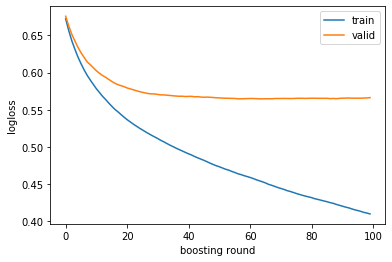

In [21]:
train_run = workflow.run(
    name = 'train_model',
    handler=train,
    inputs={
        'xtrain': split_run.output('xtrain'),
        'ytrain': split_run.output('ytrain'),
        'xvalid': split_run.output('xvalid'),
        'yvalid': split_run.output('yvalid')},
    params={
        'target_path': TARGET_PATH,
        'losses_name': 'train_valid_losses.csv',
        'losses_key':  'train_valid_losses',
        'model_name':  MODEL_NAME,
        'model_key' :  'model'})

[mlrun] 2020-01-11 14:55:37,444 type: <class 'numpy.float64'>   value: 0.7025



uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...3be10b,0,Jan 11 14:55:37,completed,test_model,host=jupyter-1-c9b85d6f7-4ktx7,modelxtestytest,,accuracy=0.7025,roc-curve.html


to track results use .show() or .logs() or in CLI: 
!mlrun get run b790883789a34955b74efdcfec3be10b  , !mlrun logs b790883789a34955b74efdcfec3be10b 
[mlrun] 2020-01-11 14:55:37,625 run executed, status=completed


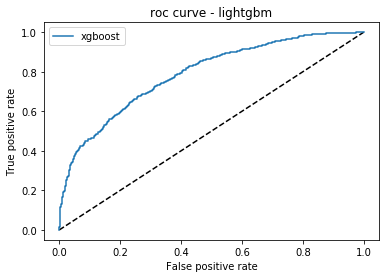

In [22]:
test_run = workflow.run(
    name = 'test_model',
    handler=test,
    inputs={
        'model': train_run.output('model'),
        'xtest': split_run.output('xtest'),
        'ytest': split_run.output('ytest')})

uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...c9a1c2,0,Jan 11 14:55:37,completed,feature_importance,host=jupyter-1-c9b85d6f7-4ktx7,modelxtest,target_path=/User/mlrun/lightgbm/,,feature-importancesfeature-importances-plot.html


to track results use .show() or .logs() or in CLI: 
!mlrun get run 41aaa1518326491bb67d8d1a86c9a1c2  , !mlrun logs 41aaa1518326491bb67d8d1a86c9a1c2 
[mlrun] 2020-01-11 14:55:38,238 run executed, status=completed


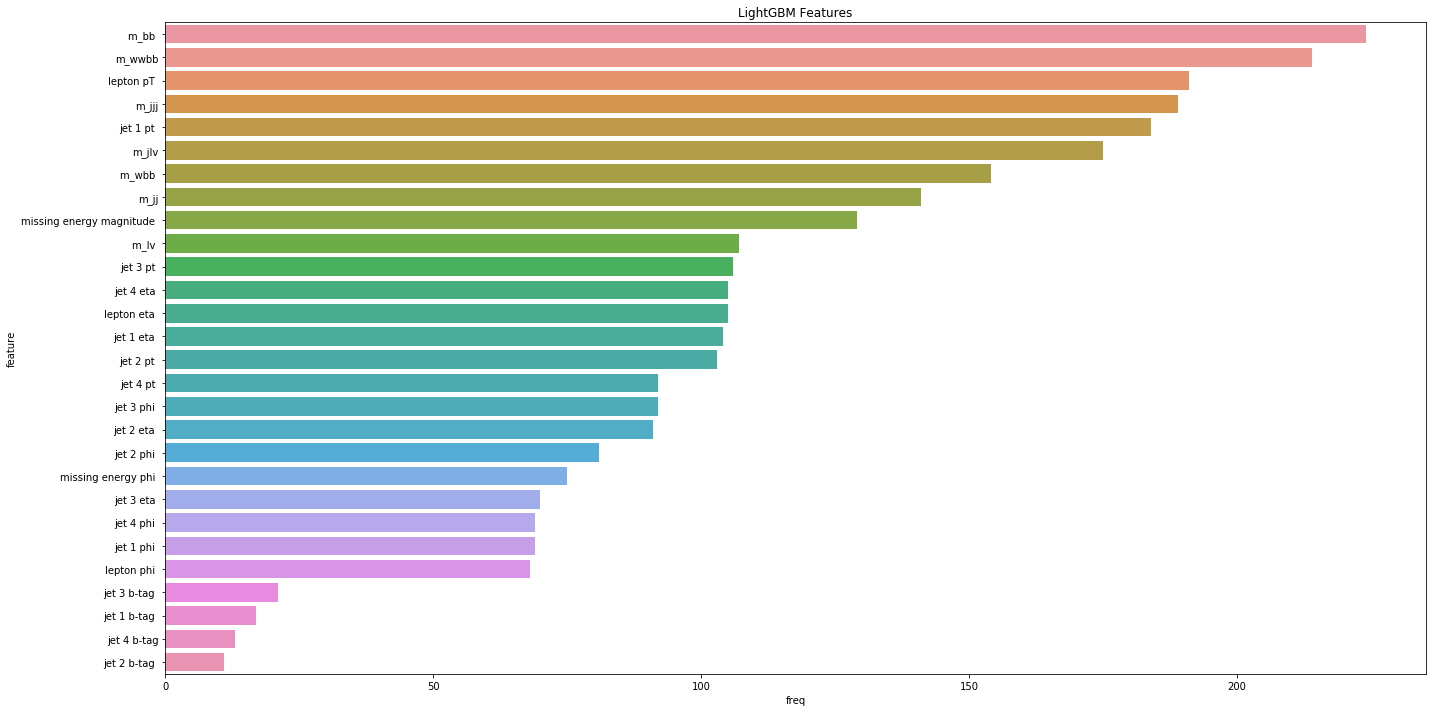

In [23]:
importance_run = workflow.run(
    name = 'feature_importance',
    handler=importance,
    inputs={
        'model': train_run.output('model'),
        'xtest': split_run.output('xtest')},
    params={
        'target_path': TARGET_PATH})

<a id="image"></a>
### Create a deployment image

Once debugged you can create a reusable image, and then deploy it for testing. In the following line we are converting the code block between the ```#nuclio: ignore``` and ```#nuclio: end-code``` to be run as a KubeJob.   _**It is important to ensure that this image has been built at least once, and that you have access to it.**_

In [24]:
lgbm_job = code_to_function(name='lgbm_job', runtime='job').apply(mount_v3io())

In [25]:
lgbm_job.deploy()

[mlrun] 2020-01-11 14:55:42,126 starting remote build, image: .mlrun/func-default-lgbm-job-latest
INFO[0000] Resolved base name python:3.6-jessie to python:3.6-jessie 
INFO[0000] Resolved base name python:3.6-jessie to python:3.6-jessie 
INFO[0000] Downloading base image python:3.6-jessie     
INFO[0000] Error while retrieving image from cache: getting file info: stat /cache/sha256:0318d80cb241983eda20b905d77fa0bfb06e29e5aabf075c7941ea687f1c125a: no such file or directory 
INFO[0000] Downloading base image python:3.6-jessie     
INFO[0000] Built cross stage deps: map[]                
INFO[0000] Downloading base image python:3.6-jessie     
INFO[0000] Error while retrieving image from cache: getting file info: stat /cache/sha256:0318d80cb241983eda20b905d77fa0bfb06e29e5aabf075c7941ea687f1c125a: no such file or directory 
INFO[0000] Downloading base image python:3.6-jessie     
INFO[0000] Unpacking rootfs as cmd RUN pip install git+https://github.com/mlrun/mlrun.git@development requires 

True

While debugging, and _**after you have run**_ ```deploy``` **at least once**, you can comment out the last cell so that the build process isn't started needlessly.  Any code changes made after the image has been built and deployed can be injected into the job using the following line (so long as the changes don't include adding or deleting packages):

In [ ]:
#lgbm_job.with_code()

____

### test your code remotely

In [26]:
task = NewTask()

task.with_params(target_path=TARGET_PATH,
                 src_file='raw.parquet',
                 sample=-20000,
                 test_size=0.1)

nrun = lgbm_job.run(task, handler='split', out_path=TARGET_PATH)

[mlrun] 2020-01-11 15:00:07,912 starting run split uid=0c8dd9f4f8134866b0f4d2fd6aa7ce25  -> http://mlrun-api:8080
[mlrun] 2020-01-11 15:00:26,923 reading original at /User/mlrun/lightgbm/raw.parquet
[mlrun] 2020-01-11 15:00:31,359 input 20000 rows
[mlrun] 2020-01-11 15:00:31,359 splitting into train-valid-test data sets

[mlrun] 2020-01-11 15:00:31,645 run executed, status=completed
final state: succeeded


uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...a7ce25,0,Jan 11 15:00:26,completed,lgbm-job,host=split-ljqvgkind=jobowner=admin,,sample=-20000src_file=raw.parquettarget_path=/User/mlrun/lightgbm/test_size=0.1,,xtrainxvalidxtestytrainyvalidytest


to track results use .show() or .logs() or in CLI: 
!mlrun get run 0c8dd9f4f8134866b0f4d2fd6aa7ce25  , !mlrun logs 0c8dd9f4f8134866b0f4d2fd6aa7ce25 
[mlrun] 2020-01-11 15:00:37,355 run executed, status=completed


In [27]:
task.with_params(target_path=TARGET_PATH,
                 losses_name='train_valid_losses.csv',
                 losses_key='train_valid_losses',
                 model_name=MODEL_NAME,
                 model_key='model')

nrun2 = lgbm_job.run(task,
                     handler='train',
                     inputs = {
                          'xtrain': nrun.outputs['xtrain'],
                          'ytrain':nrun.outputs['ytrain'],
                          'xvalid':nrun.outputs['xvalid'],
                          'yvalid':nrun.outputs['yvalid']},
                     out_path=TARGET_PATH)

[mlrun] 2020-01-11 15:00:37,362 starting run train uid=6532797d68244db5bf349df9430c7680  -> http://mlrun-api:8080
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[mlrun] 2020-01-11 15:01:03,010 read tables
[mlrun] 2020-01-11 15:01:03,075 training input 13500 rows
[mlrun] 2020-01-11 15:01:03,075 starting train

[mlrun] 2020-01-11 15:01:19,814 run executed, status=completed
final state: succeeded


uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...0c7680,0,Jan 11 15:01:02,completed,lgbm-job,host=train-f4rwjkind=jobowner=admin,xtrainxvalidytrainyvalid,losses_key=train_valid_losseslosses_name=train_valid_losses.csvmodel_key=modelmodel_name=lightgbm.model.pkltarget_path=/User/mlrun/lightgbm/,,train_valid_lossesclassifier-training.htmlmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run 6532797d68244db5bf349df9430c7680  , !mlrun logs 6532797d68244db5bf349df9430c7680 
[mlrun] 2020-01-11 15:01:27,081 run executed, status=completed


In [28]:
nrun3 = lgbm_job.run(task,
                     handler='test',
                     inputs = {
                         'model': nrun2.outputs['model'],
                         'xtest': nrun.outputs['xtest'],
                         'ytest': nrun.outputs['ytest']},
                     out_path=TARGET_PATH)

[mlrun] 2020-01-11 15:01:27,087 starting run test uid=f0d38e0e0f854b39a5fbc9ddd8753014  -> http://mlrun-api:8080
[mlrun] 2020-01-11 15:01:36,935 type: <class 'numpy.float64'>   value: 0.712

[mlrun] 2020-01-11 15:01:37,447 run executed, status=completed
final state: succeeded


uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...753014,0,Jan 11 15:01:36,completed,lgbm-job,host=test-hq5lfkind=jobowner=admin,modelxtestytest,losses_key=train_valid_losseslosses_name=train_valid_losses.csvmodel_key=modelmodel_name=lightgbm.model.pkltarget_path=/User/mlrun/lightgbm/,accuracy=0.712,roc-curve.html


to track results use .show() or .logs() or in CLI: 
!mlrun get run f0d38e0e0f854b39a5fbc9ddd8753014  , !mlrun logs f0d38e0e0f854b39a5fbc9ddd8753014 
[mlrun] 2020-01-11 15:01:46,498 run executed, status=completed


In [29]:
nrun4 = lgbm_job.run(task,
                     handler='importance',
                     inputs={
                        'model': train_run.output('model'),
                        'xtest': split_run.output('xtest')},
                     params={'target_path': TARGET_PATH})

[mlrun] 2020-01-11 15:01:46,505 starting run importance uid=fb778a324bc44916a4d47b0c1b03c212  -> http://mlrun-api:8080
[mlrun] 2020-01-11 15:01:56,610 run executed, status=completed
final state: succeeded


uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...03c212,0,Jan 11 15:01:55,completed,lgbm-job,host=importance-xdn49kind=jobowner=admin,modelxtest,target_path=/User/mlrun/lightgbm/,,feature-importancesfeature-importances-plot.html


to track results use .show() or .logs() or in CLI: 
!mlrun get run fb778a324bc44916a4d47b0c1b03c212  , !mlrun logs fb778a324bc44916a4d47b0c1b03c212 
[mlrun] 2020-01-11 15:02:05,837 run executed, status=completed


<a id="pipeline"></a>
### Create a KubeFlow Pipeline from our functions

Our pipeline will consist of two instead of three steps, ```load``` and ```train```.  We'll drop the ```test```
here since at the end of this deployment we can test the system with API requests.

For complete details on KubeFlow Pipelines please refer to the following docs:
1. **[KubeFlow pipelines](https://www.kubeflow.org/docs/pipelines/)**.
2. **[kfp.dsl Python package](https://kubeflow-pipelines.readthedocs.io/en/latest/source/kfp.dsl.html#module-kfp.dsl)**.

Please note, the model server file name in the ```new_model_server``` function call below should identical in every respect to the name of the model server notebook.

In [30]:
import kfp
from kfp import dsl

In [31]:
# define a nuclio-serving function, generated from a notebook file
srvfn = new_model_server('model_A', 
                         model_class='LGBoostModel', 
                         filename='model-server.ipynb')
srvfn.apply(mount_v3io())

In [32]:
@dsl.pipeline(name='LGBM & HIGGS', description='lightgbm classifier')
def lgbm_pipeline(learning_rate = [0.1, 0.3], num_leaves = [31, 32]):
    acquire_step = lgbm_job.as_step(
            name='acquire_remote_data',
            handler='acquire',
            params={
                'archive_url': ARCHIVE_URL,
                'name':        'raw',
                'target_path': TARGET_PATH},
            outputs=['raw'], 
            out_path=TARGET_PATH).apply(mount_v3io())
    
    split_step = lgbm_job.as_step(
            name='split_data',
            handler='split',
            params={'sample': -20_000, 'target_path': TARGET_PATH},
            outputs=['xtrain', 'ytrain', 'xvalid', 'yvalid', 'xtest', 'ytest'], 
            out_path=TARGET_PATH).apply(mount_v3io()).after(acquire_step)

    train_step = lgbm_job.as_step(
            name='train_model', 
            handler='train',
            params = {
                'target_path': TARGET_PATH,
                'losses_name': 'train_valid_losses.csv',
                'losses_key':  'train_valid_losses',
                'model_name':  MODEL_NAME,
                'model_key':   'model'
                },
            inputs = {'xtrain': split_step.outputs['xtrain'],
                      'ytrain': split_step.outputs['ytrain'],
                      'xvalid': split_step.outputs['xvalid'],
                      'yvalid': split_step.outputs['yvalid']}, 
            outputs=['model'],
            out_path= TARGET_PATH).apply(mount_v3io())

    test_step = lgbm_job.as_step(
        name='test_model',
        handler='test',
        inputs = {'model': train_step.outputs['model'],
                  'xtest': split_step.outputs['xtest'],
                  'ytest': split_step.outputs['ytest']}, 
        out_path=TARGET_PATH).apply(mount_v3io())

    importance_step = lgbm_job.as_step(
        name='importance_model',
        handler='importance',
        inputs = {'model': train_step.outputs['model'],
                  'xtest': split_step.outputs['xtest']},
        out_path=TARGET_PATH).apply(mount_v3io())

    srvfn.deploy_step(project='github-demos', 
                      models={'lgbm_joblib': train_step.outputs['model']})

<a id="compile the pipeline"></a>
### compile the pipeline

We can compile our KubeFlow pipeline and produce a yaml description of the pipeline worflow:

In [33]:
kfp.compiler.Compiler().compile(lgbm_pipeline, TARGET_PATH + '/mlrunpipe.yaml')

/User/.pythonlibs/jupyter-1/lib/python3.6/site-packages/kfp/components/_data_passing.py:133: UserWarning: Missing type name was inferred as "JsonArray" based on the value "[0.1, 0.3]".
  warnings.warn('Missing type name was inferred as "{}" based on the value "{}".'.format(type_name, str(value)))
/User/.pythonlibs/jupyter-1/lib/python3.6/site-packages/kfp/components/_data_passing.py:133: UserWarning: Missing type name was inferred as "JsonArray" based on the value "[31, 32]".
  warnings.warn('Missing type name was inferred as "{}" based on the value "{}".'.format(type_name, str(value)))


In [34]:
client = kfp.Client(namespace='default-tenant')

Finally, the following line will run the pipeline as a job::

In [35]:
arguments = {
    'learning_rate': [ 0.1, 0.3],
    'num_leaves':    [31, 32]}

run_result = client.create_run_from_pipeline_func(
    lgbm_pipeline, 
    arguments, 
    run_name='my lgbm run',
    experiment_name='lgbm')